In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset
df = pd.read_csv("tweets_with_roberta_sentiment.csv")

# Drop rows with missing clean_text or sentiment
df = df.dropna(subset=["clean_text", "roberta_sentiment"])

# Encode sentiment labels
label_encoder = LabelEncoder()
df["sentiment_label"] = label_encoder.fit_transform(df["roberta_sentiment"])

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])

# Pad sequences to a max length
max_length = 30
X = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Labels
y = df["sentiment_label"].values

# Check label encoding
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),  # Removed input_length
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)


Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4193 - loss: 1.0735 - val_accuracy: 0.5011 - val_loss: 1.0210
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5459 - loss: 0.9552 - val_accuracy: 0.5959 - val_loss: 0.8272
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6274 - loss: 0.7149 - val_accuracy: 0.5672 - val_loss: 0.9168
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6647 - loss: 0.6082 - val_accuracy: 0.5810 - val_loss: 0.9461
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7006 - loss: 0.5642 - val_accuracy: 0.6290 - val_loss: 1.0531


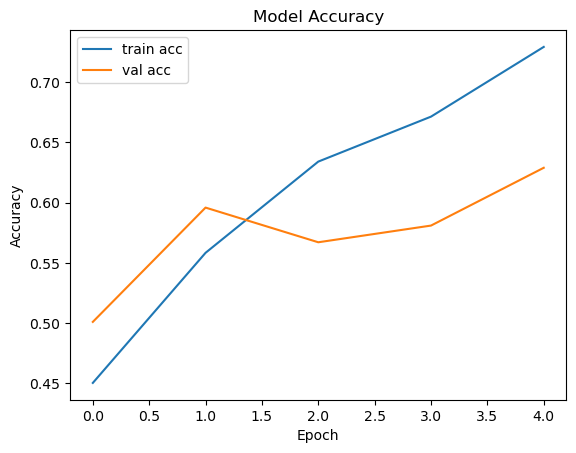

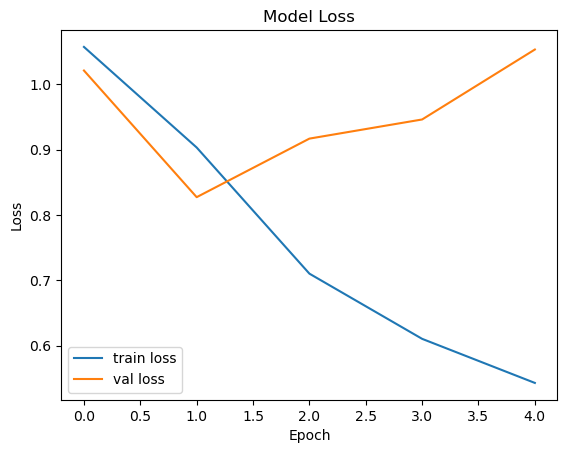

In [6]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
📋 Classification Report:

              precision    recall  f1-score   support

    negative       0.52      0.05      0.09       277
     neutral       0.36      0.01      0.02       405
    positive       0.27      0.96      0.42       256

    accuracy                           0.28       938
   macro avg       0.39      0.34      0.18       938
weighted avg       0.39      0.28      0.15       938



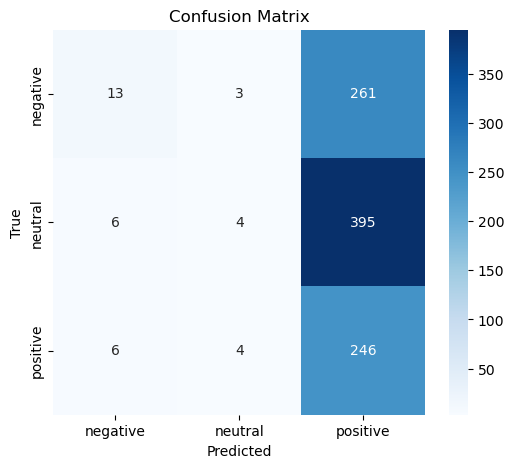

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Then train like this:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=32,
          class_weight=class_weights_dict)


{0: 1.220703125, 1: 0.7783312577833126, 2: 1.1160714285714286}
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4276 - loss: 1.0720 - val_accuracy: 0.6194 - val_loss: 0.8674
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6731 - loss: 0.7216 - val_accuracy: 0.7100 - val_loss: 0.7043
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8564 - loss: 0.3877 - val_accuracy: 0.7409 - val_loss: 0.7017
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9132 - loss: 0.2392 - val_accuracy: 0.7324 - val_loss: 0.8262
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9465 - loss: 0.1626 - val_accuracy: 0.7249 - val_loss: 0.8885
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9570 - loss: 0.1241 - val_accuracy: 0.7207 - val_loss: 1.0201
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9668 - loss: 0.0990 - val_accuracy: 0.7122 - val_loss: 1.2866
Epoch 8/10
118/118 ━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
📋 Updated Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.68      0.72       277
     neutral       0.71      0.75      0.73       405
    positive       0.67      0.69      0.68       256

    accuracy                           0.71       938
   macro avg       0.71      0.71      0.71       938
weighted avg       0.71      0.71      0.71       938



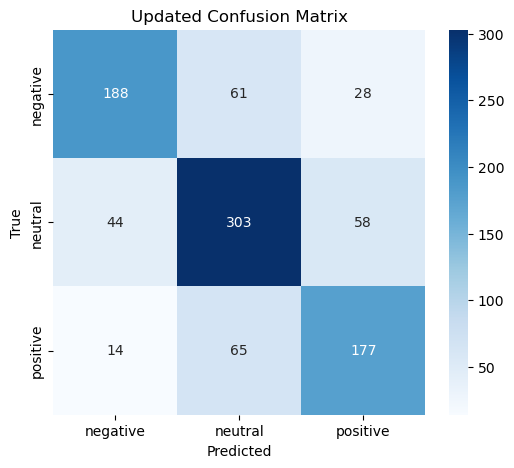

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict again
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📋 Updated Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Updated Confusion Matrix")
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler

# Pick numeric features to include
numeric_cols = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'view_count', 'bookmark_count']

# Scale them
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols])


In [14]:
# Assume you've already done this:
# X - padded text sequences
# scaled_numeric - scaled numeric features
# y - encoded sentiment labels

# Train/test split
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X, scaled_numeric, y, test_size=0.2, random_state=42)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate

# Text input branch
text_input = Input(shape=(X.shape[1],), name='text_input')
x = Embedding(input_dim=10000, output_dim=128)(text_input)
x = LSTM(128)(x)
x = Dropout(0.5)(x)

# Numeric input branch
num_input = Input(shape=(X_num_train.shape[1],), name='num_input')
n = Dense(64, activation='relu')(num_input)
n = Dropout(0.3)(n)

# Combine branches
combined = Concatenate()([x, n])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(3, activation='softmax')(z)

# Create model
model = Model(inputs=[text_input, num_input], outputs=output)

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 30, 128)           │       1,280,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ num_input (InputLayer)        │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 128)               │         131,584 │ embedding_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 64)                │             448 │ num_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ lstm_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 64)                │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 192)               │               0 │ dropout_3[0][0],           │
│                               │                           │                 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 64)                │          12,352 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 64)                │               0 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 3)                 │             195 │ dropout_5[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,424,579 (5.43 MB)

 Trainable params: 1,424,579 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(
    {'text_input': X_text_train, 'num_input': X_num_train},
    y_train,
    validation_data=(
        {'text_input': X_text_test, 'num_input': X_num_test}, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4260 - loss: 1.0706 - val_accuracy: 0.5458 - val_loss: 0.9546
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5561 - loss: 0.8718 - val_accuracy: 0.5896 - val_loss: 0.8375
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6321 - loss: 0.7374 - val_accuracy: 0.5981 - val_loss: 0.8985
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6723 - loss: 0.6297 - val_accuracy: 0.5938 - val_loss: 0.9857
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6760 - loss: 0.5762 - val_accuracy: 0.6013 - val_loss: 0.8766
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6767 - loss: 0.5793 - val_accuracy: 0.5522 - val_loss: 1.1168
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6406 - loss: 0.6995 - val_accuracy: 0.5757 - val_loss: 1.0485
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.7516 - loss: 0.5199 - val_ac

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
📋 Classification Report (Hybrid Model):

              precision    recall  f1-score   support

    negative       0.76      0.70      0.73       277
     neutral       0.74      0.67      0.70       405
    positive       0.60      0.73      0.66       256

    accuracy                           0.70       938
   macro avg       0.70      0.70      0.70       938
weighted avg       0.70      0.70      0.70       938



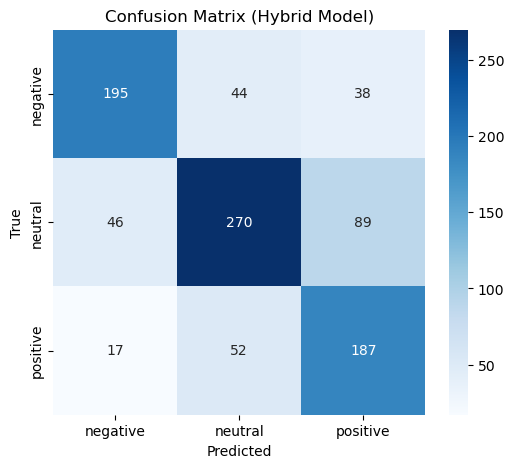

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict({
    'text_input': X_text_test,
    'num_input': X_num_test
})
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("📋 Classification Report (Hybrid Model):\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Hybrid Model)')
plt.show()

